In [1]:
import sys
import os

# Add the root directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

from dsa_analysis import load_config, visualize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import interpolate
import main
from main import RNNLayer

%load_ext autoreload
%autoreload 2

/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(


### Load config

In [2]:
config = load_config("../config.yaml")

In [3]:
def parse_model_info(model_name):
    model_name = model_name.replace('.pth', '')
    model_name = model_name.split('_')
    model_type = model_name[0] + '_' + model_name[1]
    if len(model_name) == 8:    
        activation = model_name[2] + '_' + model_name[3]
        hidden_size = int(model_name[4])
        learning_rate = float(model_name[5])
        batch_size = int(model_name[6])
    else:
        activation = model_name[2]
        hidden_size = int(model_name[3])
        learning_rate = float(model_name[4])
        batch_size = int(model_name[5])
    return model_type, activation, hidden_size, learning_rate, batch_size

parse_model_info('leaky_gru_leaky_relu_128_0.001_128_train.pth')



('leaky_gru', 'leaky_relu', 128, 0.001, 128)

In [4]:
def get_dynamics_model(rnn_type, activation, hidden_size, lr, model, group,device, n_components=3):
    # Load configuration and set hyperparameters
    config = load_config("../config.yaml")
    ruleset = config["rules_analysis"][-1]
    all_rules = config["rules_analysis"]

    hp = {
        "rnn_type": rnn_type,
        "activation": activation,
        "n_rnn": hidden_size,
        "learning_rate": lr,
        "l2_h": 0.00001,
        "l2_weight": 0.00001,
        "mode": "test",
    }
    hp, _, _ = main.set_hyperparameters(
        model_dir="debug", hp=hp, ruleset=all_rules, rule_trains=ruleset
    )
    run_model = main.load_model(
        f"../models/{group}/{model}",
        hp,
        RNNLayer,
        device=device,
    )
    h = main.representation(run_model, all_rules)
    h_trans, explained_variance = main.compute_pca(h, n_components=n_components)
    tensor_on_cpu = h_trans[("AntiPerceptualDecisionMakingDelayResponseT", "stimulus")].cpu()
    return tensor_on_cpu.detach().numpy(), explained_variance

### Get dynamics to plot

In [5]:
group = "master"
model = "leaky_gru_leaky_relu_128_0.001_128_train.pth"
model_type, activation, hidden_size, lr, batch_size = parse_model_info(model)
curve, explained_variance = get_dynamics_model(
    model_type, activation, hidden_size, lr, model, group, "cpu", n_components=3 
)

/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(
/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(
/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(
/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.

#### Visualize the curves

/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


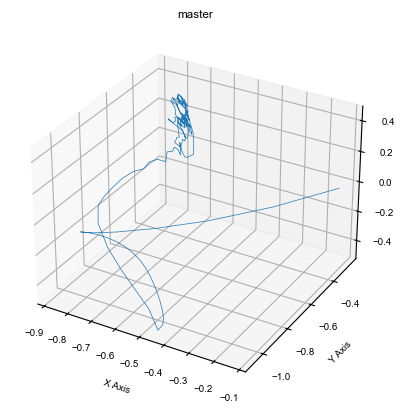

In [6]:
visualize([curve[:,150,:]],title=group)

### Get dissimilarities

#### Computation dynamics

In [7]:
# load data
path = "../data/dissimilarities"
files = os.listdir(path)
data = []
for file in files:
    if file.endswith(".csv"):
        df = pd.read_csv(os.path.join(path, file))
        data.append(df)
data = pd.concat(data)
data_groupes_mean_dissimilarity = data.groupby(['group1', 'group2'])[["cka","procrustes","dsa"]].mean().reset_index()
data_models = data[data['model1'] == data['model2']].groupby(['group1', 'group2','model1','model2'])[["cka","procrustes","dsa"]].mean().reset_index()
data_models_averaged = data_models.groupby(['group1', 'group2'])[["cka","procrustes","dsa"]].mean().reset_index()

##### Dissimilarities Many to Many models

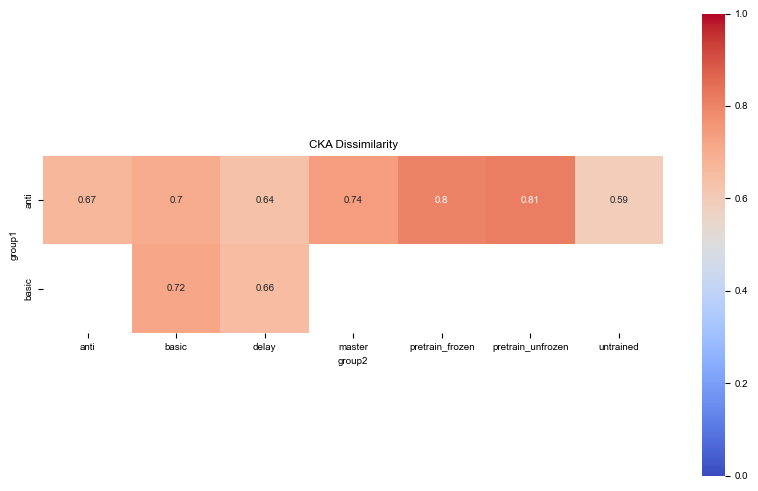

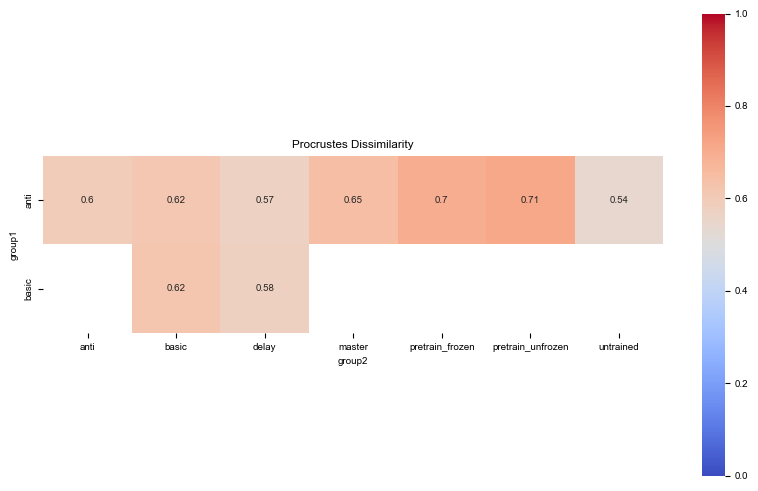

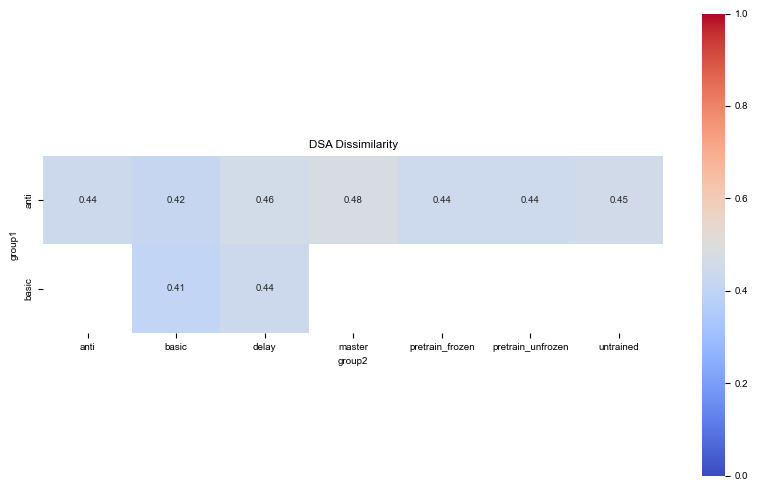

In [8]:
# plot heatmap of the dissimilarity between the groups
df = pd.DataFrame(data_groupes_mean_dissimilarity)

# Pivot the dataframe to prepare for heatmap
pivot_df = df.pivot(index='group1', columns='group2', values=['cka', 'procrustes', 'dsa'])

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_df['cka'], annot=True, cmap='coolwarm', cbar=True, vmin=0, vmax=1, square=True)
plt.title('CKA Dissimilarity')
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_df['procrustes'], annot=True, cmap='coolwarm', cbar=True, vmin=0, vmax=1, square=True)
plt.title('Procrustes Dissimilarity')
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_df['dsa'], annot=True, cmap='coolwarm', cbar=True, vmin=0, vmax=1, square=True)
plt.title('DSA Dissimilarity')
plt.show()

##### Dissimilarities One to One models

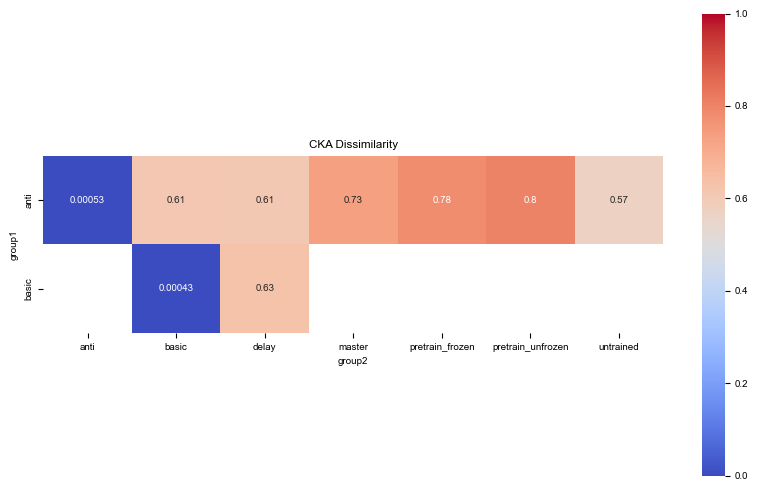

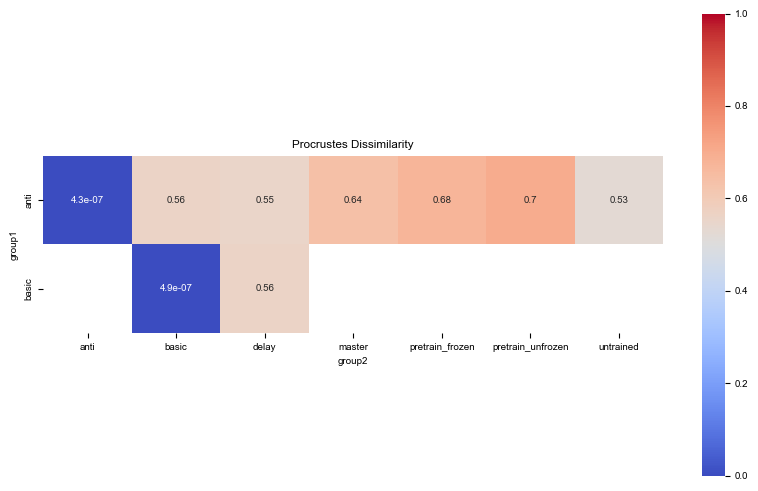

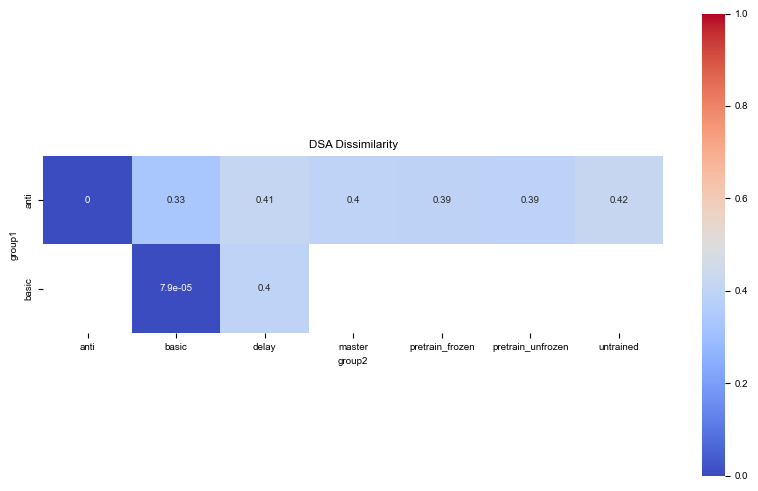

In [9]:
# plot heatmap of the dissimilarity between the groups
df = pd.DataFrame(data_models_averaged)

# Pivot the dataframe to prepare for heatmap
pivot_df = df.pivot(index='group1', columns='group2', values=['cka', 'procrustes', 'dsa'])

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_df['cka'], annot=True, cmap='coolwarm', cbar=True, vmin=0, vmax=1, square=True)
plt.title('CKA Dissimilarity')
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_df['procrustes'], annot=True, cmap='coolwarm', cbar=True, vmin=0, vmax=1, square=True)
plt.title('Procrustes Dissimilarity')
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_df['dsa'], annot=True, cmap='coolwarm', cbar=True, vmin=0, vmax=1, square=True)
plt.title('DSA Dissimilarity')
plt.show()

#### Learning dynamics

For now, only analysis for pretrain_frozen against pretrain_unfrozen

In [10]:
path = "../data/dissimilarities_over_learning"
files = os.listdir(path)
data = []
for file in files:
    if file.endswith(".csv"):
        df = pd.read_csv(os.path.join(path, file))
        data.append(df)
df = pd.concat(data)

In [15]:
for _, row in df.iterrows():
    print(len(row["cka"]))

991
994
2
338
992
993
19
100
997
994
20
20
897
996
59
20
999
1019
996
997
992
1019
992
991
998
990
477
990
991
994
890
994
996
993
397
597
874
993
99
458
997
992
40
755
360
991
80
118
996
995
99
991
993
991
553
991
814
996
59
159
219
992
40
374


In [14]:
# Common percentage points for interpolation
common_percent = np.linspace(0, 100, 5)

# Function to create a unique identifier for each model
def create_model_id(row):
    return f"{row['group1']}_{row['group2']}_{row['rnn_type']}_{row['activation']}_{row['hidden_size']}_{row['lr']}_{row['batch_size']}"

# Add a model_id column to the DataFrame
df['model_id'] = df.apply(create_model_id, axis=1)

# List of dissimilarity measures
measures = ['cka', 'procrustes', 'dsa']

# Create a plot for each measure
for measure in measures:
    plt.figure(figsize=(12, 8))
    
    for _, row in df.iterrows():
        model_id = row['model_id']
        dissimilarities = row[measure]
        print(len(dissimilarities))
        # Calculate the percentage points for this model
        percent = np.linspace(0, 100, len(dissimilarities))
        print(len(percent))
        # Interpolate
        f = interpolate.interp1d(percent, dissimilarities)
        interpolated_dissimilarity = f(common_percent)
        
        # Plot
        plt.plot(common_percent, interpolated_dissimilarity, label=model_id)
    
    plt.xlabel('% of Training')
    plt.ylabel(f'{measure.upper()} Dissimilarity')
    plt.title(f'{measure.upper()} Dissimilarity vs % of Training for Different Models')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

991
991


ValueError: x and y arrays must be equal in length along interpolation axis.

<Figure size 1200x800 with 0 Axes>